## Import file json kaggle

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/uang kertas 2024'

/content/drive/MyDrive/uang kertas 2024


# Analisis Klasifikasi Uang Kertas dengan Berbagai Metode

## Import Library

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from PIL import Image
from skimage import io, color, filters
from skimage.measure import shannon_entropy
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, classification_report,
                           confusion_matrix, roc_curve, auc)
import joblib
import warnings
warnings.filterwarnings('ignore')

## Load dan Persiapan Data

In [4]:
# Path ke dataset yang sudah diekstrak
dataset_dir = '/content/drive/MyDrive/uang kertas 2024/dataset uang rupiah'

## Distribusi Sebaran Dataset

In [5]:
# Mendapatkan daftar kelas (subfolder) dalam dataset
classes = os.listdir(dataset_dir)

# Menghitung jumlah file gambar per kelas
class_counts = {}
for cls in classes:
    class_dir = os.path.join(dataset_dir, cls)
    if os.path.isdir(class_dir):
        # Perbarui filter untuk menyertakan lebih banyak ekstensi
        image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG'))]
        class_counts[cls] = len(image_files)

# Menampilkan distribusi sebaran dataset
print("Distribusi Sebaran Dataset:")
for cls, count in class_counts.items():
    print(f"{cls}: {count} sampel")


Distribusi Sebaran Dataset:
7. seratus ribu: 20 sampel
2. dua ribu: 20 sampel
5. dua puluh ribu: 20 sampel
1. seribu: 20 sampel
3. lima ribu: 20 sampel
6. lima puluh ribu: 20 sampel
4. sepuluh ribu: 20 sampel


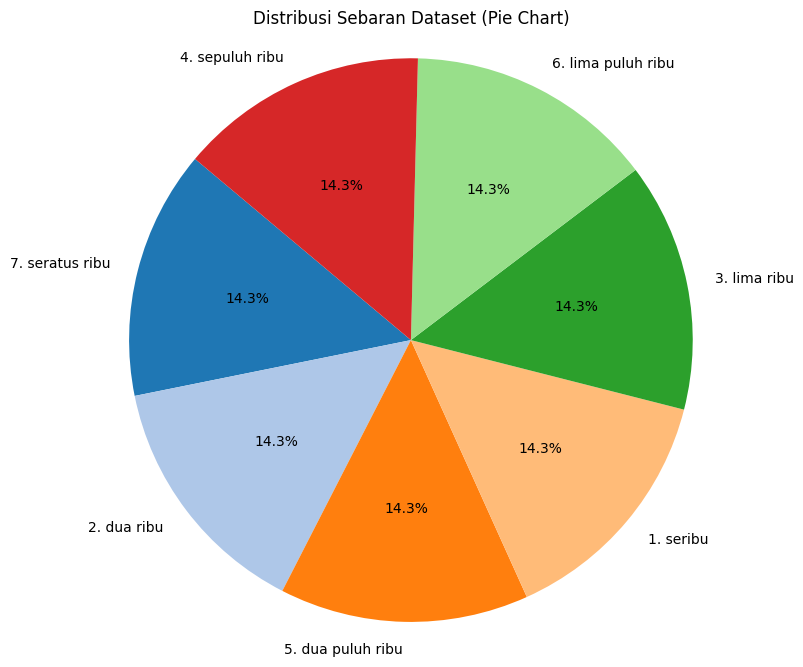

In [6]:
# Data untuk pie chart
labels = list(class_counts.keys())
sizes = list(class_counts.values())
colors = plt.cm.tab20.colors[:len(labels)]

# Membuat pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Distribusi Sebaran Dataset (Pie Chart)')
plt.axis('equal')
plt.show()

# Augmentasi

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img, save_img
import os
import numpy as np

# Path folder tujuan hasil augmentasi
augmented_dir = 'augmented_dataset_8'
os.makedirs(augmented_dir, exist_ok=True)

# Setup ImageDataGenerator untuk augmentasi
datagen = ImageDataGenerator(
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    fill_mode='nearest'
)

# Jumlah augmentasi per gambar
augment_per_image = 4

# Proses augmentasi per kelas
for cls in class_counts:
    class_input_dir = os.path.join(dataset_dir, cls)
    class_output_dir = os.path.join(augmented_dir, cls)
    os.makedirs(class_output_dir, exist_ok=True)

    image_files = [f for f in os.listdir(class_input_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    for image_name in image_files:
        img_path = os.path.join(class_input_dir, image_name)
        img = load_img(img_path)  # PIL image
        x = img_to_array(img)     # Numpy array
        x = x.reshape((1,) + x.shape)

        # gambar asli
        save_img(os.path.join(class_output_dir, image_name), x[0])

        # augmentasi
        i = 0
        for batch in datagen.flow(x, batch_size=1):
            aug_img_path = os.path.join(class_output_dir, f"aug_{i}_{image_name}")
            save_img(aug_img_path, batch[0])
            i += 1
            if i >= augment_per_image:
                break




In [10]:
import os

# Path ke folder combined dataset
jumlah_augmentasi= '/content/drive/MyDrive/uang kertas 2024/augmented_dataset_8'

# Menampilkan jumlah gambar per kelas
for cls in os.listdir(jumlah_augmentasi):
    class_dir = os.path.join(jumlah_augmentasi, cls)

    if os.path.isdir(class_dir):  # Pastikan hanya folder yang dihitung
        # Hitung jumlah gambar dalam folder kelas
        image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        print(f"Kelas {cls}: {len(image_files)} gambar")


Kelas 7. seratus ribu: 80 gambar
Kelas 2. dua ribu: 80 gambar
Kelas 5. dua puluh ribu: 80 gambar
Kelas 1. seribu: 80 gambar
Kelas 3. lima ribu: 80 gambar
Kelas 6. lima puluh ribu: 80 gambar
Kelas 4. sepuluh ribu: 80 gambar


In [ ]:
import os
import shutil

original_dir = '/content/drive/MyDrive/uang kertas 2024/dataset uang rupiah'  # folder data asli
augmented_dir = '/content/drive/MyDrive/uang kertas 2024/augmented_dataset_8'  # folder hasil augmentasi
combined_dir = '/content/drive/MyDrive/uang kertas 2024/combined_dataset_v8'  # folder hasil gabungan

os.makedirs(combined_dir, exist_ok=True)

# Gabungkan isi setiap kelas
for class_name in os.listdir(original_dir):
    original_class_path = os.path.join(original_dir, class_name)
    augmented_class_path = os.path.join(augmented_dir, class_name)
    combined_class_path = os.path.join(combined_dir, class_name)

    os.makedirs(combined_class_path, exist_ok=True)

    # Salin gambar asli
    for fname in os.listdir(original_class_path):
        src = os.path.join(original_class_path, fname)
        dst = os.path.join(combined_class_path, f"ori_{fname}")
        shutil.copyfile(src, dst)

    # Salin gambar augmentasi
    if os.path.exists(augmented_class_path):
        for fname in os.listdir(augmented_class_path):
            src = os.path.join(augmented_class_path, fname)
            dst = os.path.join(combined_class_path, f"aug_{fname}")
            shutil.copyfile(src, dst)

In [11]:
combined_dir = '/content/drive/MyDrive/uang kertas 2024/combined_dataset_v8'

#Fungsi untuk ekstraksi fitur dasar

In [12]:
def extract_basic_features(image_path):
    img = io.imread(image_path)
    if img.shape[2] == 4:
        img = img[:, :, :3]
    gray_img = color.rgb2gray(img)
    pixels = gray_img.flatten()

    features = {
        'mean': np.mean(pixels),
        'std_dev': np.std(pixels),
        'entropy': shannon_entropy(pixels),
        'contrast': np.max(pixels) - np.min(pixels),
        'energy': np.sum(pixels**2) / np.prod(pixels.shape)
    }
    return features

#Ekstraksi fitur dari dataset

In [13]:
from skimage import io, color
from skimage.transform import resize
from skimage.measure import shannon_entropy
import numpy as np

def extract_basic_features(image_path, target_size=(224, 224)):
    img = io.imread(image_path)

    # Buang alpha channel jika ada
    if img.shape[2] == 4:
        img = img[:, :, :3]

    # Resize ke ukuran tetap
    img = resize(img, target_size, anti_aliasing=True)

    # Konversi ke grayscale
    gray_img = color.rgb2gray(img)

    # Flatten untuk vektor
    pixels = gray_img.flatten()

    # Ekstraksi fitur
    features = {
        'mean': np.mean(pixels),
        'std_dev': np.std(pixels),
        'entropy': shannon_entropy(pixels),
        'contrast': np.max(pixels) - np.min(pixels),
        'energy': np.sum(pixels**2) / np.prod(pixels.shape)
    }

    return features


In [14]:
data = []
for class_name in os.listdir(combined_dir):
    class_dir = os.path.join(combined_dir, class_name)
    if os.path.isdir(class_dir):
        for img_name in os.listdir(class_dir):
            if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(class_dir, img_name)
                features = extract_basic_features(img_path)
                features['label'] = class_name
                data.append(features)

In [15]:
data = pd.DataFrame(data)
data

,mean,std_dev,entropy,contrast,energy,label
0,0.411429,0.207657,15.614710,0.954477,0.212396,7. seratus ribu
1,0.421149,0.198726,15.614710,0.873426,0.216858,7. seratus ribu
2,0.418401,0.183471,15.614710,0.889074,0.208721,7. seratus ribu
3,0.441408,0.191234,15.614710,0.882365,0.231411,7. seratus ribu
4,0.435135,0.187518,15.614710,0.840075,0.224505,7. seratus ribu
...,...,...,...,...,...,...
695,0.633515,0.126411,15.484686,0.857772,0.417321,4. sepuluh ribu
696,0.594738,0.142105,15.614710,0.784592,0.373907,4. sepuluh ribu
697,0.599570,0.150191,15.548363,0.730427,0.382041,4. sepuluh ribu
698,0.604606,0.144895,15.590173,0.803285,0.386543,4. sepuluh ribu


In [16]:
# Konversi ke DataFrame
df = pd.DataFrame(data)
X = df.drop('label', axis=1)
y = df['label']

# Model 1: KNN

## Split Data

In [17]:
# Split data
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size=0.1, random_state=42)

## Fungsi Utilitas

In [18]:
def evaluate_model(model, X_test, y_test, method_name):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print(f"\n=== Evaluasi {method_name} ===")
    print(f"Akurasi: {acc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {method_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return acc

In [19]:
def plot_roc_curve(model, X_test, y_test, method_name):
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test)
    else:
        y_prob = model.decision_function(X_test)
     # ROC Curve untuk multi-class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = len(np.unique(y_test))

    # Convert y_test to numerical labels if necessary
    from sklearn.preprocessing import LabelEncoder
    if isinstance(y_test, pd.Series) and y_test.dtype == 'object':  # Check if y_test is a Series of strings
        le = LabelEncoder()
        y_test_numeric = le.fit_transform(y_test)
    else:
        y_test_numeric = y_test

    for i in range(n_classes):
        # Use numerical labels for comparison
        # **FIXED:** Create a boolean array using 'isin' for accurate comparison with string labels.
        fpr[i], tpr[i], _ = roc_curve((pd.Series(y_test).isin([le.inverse_transform([i])[0]])).astype(int), y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {method_name}')
    plt.legend(loc="lower right")
    plt.show()

In [20]:
def evaluate_model_with_cm(model, X_test, y_test, method_name, label_names=None):
    # Prediksi
    y_pred = model.predict(X_test)

    # Hitung akurasi
    acc = accuracy_score(y_test, y_pred)

    # Konversi label ke nama kalau ada label_names
    if label_names is not None:
        y_test_labels = np.vectorize(label_names.get)(y_test)
        y_pred_labels = np.vectorize(label_names.get)(y_pred)
        target_names = list(label_names.values())
    else:
        y_test_labels = y_test
        y_pred_labels = y_pred
        target_names = sorted(np.unique(y_test))

    # Classification report
    print(f"\n=== Evaluasi {method_name} ===")
    print(f"Akurasi: {acc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test_labels, y_pred_labels, target_names=target_names))

    # Confusion Matrix
    cm = confusion_matrix(y_test_labels, y_pred_labels, labels=target_names)

    # Visualisasi Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names,
                yticklabels=target_names)
    plt.title(f'Confusion Matrix - {method_name}\nAkurasi: {acc:.2%}', pad=20)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

    return acc


In [21]:
print("\n=== 1. KNN Standar ===")

# Tuning hyperparameter KNN
param_grid = {
    'n_neighbors': [3],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}


=== 1. KNN Standar ===


In [22]:
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_1, y_train_1)

best_knn = grid_search.best_estimator_
print(f"Parameter terbaik: {grid_search.best_params_}")

Parameter terbaik: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}


## Evaluasi KNN dengan Confusion Matrix

In [23]:
def evaluate_model_with_cm(model, X_test, y_test, method_name):
    # Prediksi
    y_pred = model.predict(X_test)

    # Hitung akurasi
    acc = accuracy_score(y_test, y_pred)

    # Classification report
    print(f"\n=== Evaluasi {method_name} ===")
    print(f"Akurasi: {acc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    classes = sorted(y_test.unique())

    # Visualisasi Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes,
                yticklabels=classes)
    plt.title(f'Confusion Matrix - {method_name}\nAkurasi: {acc:.2%}', pad=20)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

    return acc


=== Evaluasi KNN Standar ===

=== Evaluasi KNN Standar ===
Akurasi: 0.7714

Classification Report:
                    precision    recall  f1-score   support

         1. seribu       0.67      0.73      0.70        11
       2. dua ribu       0.85      0.92      0.88        12
      3. lima ribu       0.57      0.67      0.62         6
   4. sepuluh ribu       1.00      0.88      0.93         8
 5. dua puluh ribu       0.75      0.60      0.67        10
6. lima puluh ribu       0.80      0.92      0.86        13
   7. seratus ribu       0.75      0.60      0.67        10

          accuracy                           0.77        70
         macro avg       0.77      0.76      0.76        70
      weighted avg       0.78      0.77      0.77        70



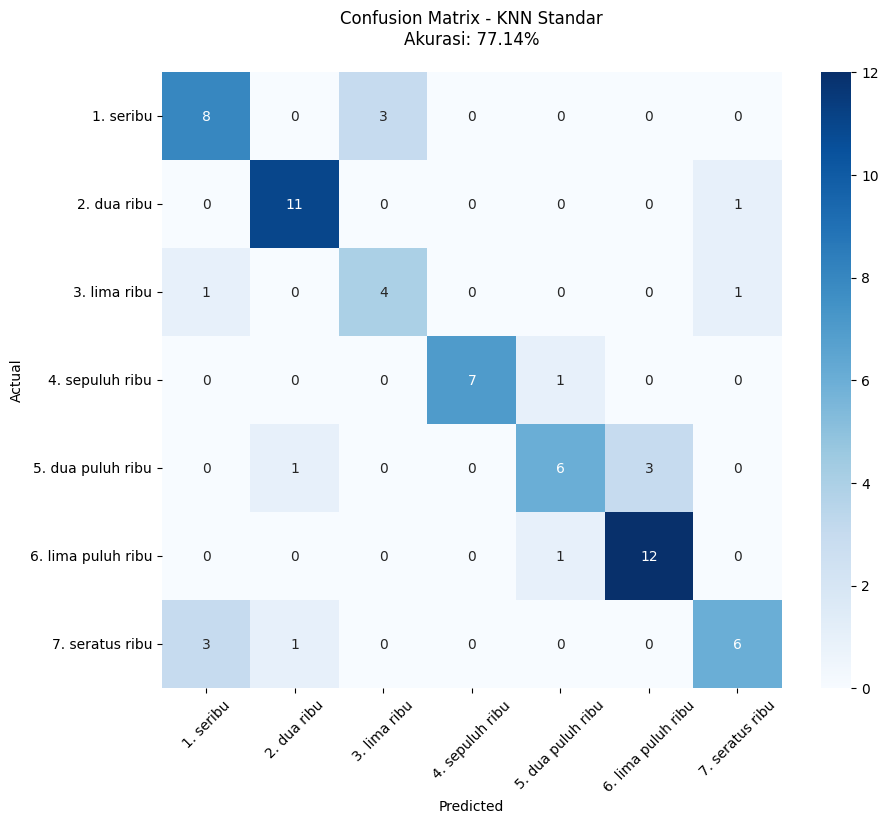

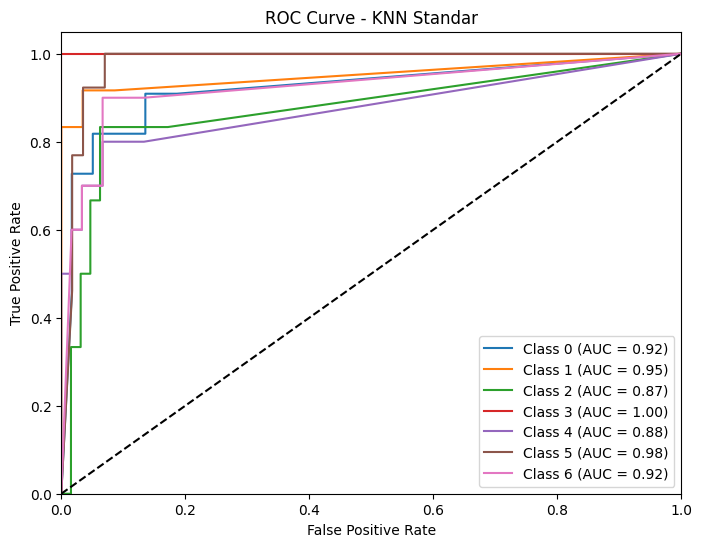

In [24]:
# Evaluasi model KNN
print("\n=== Evaluasi KNN Standar ===")
acc_knn = evaluate_model_with_cm(best_knn, X_test_1, y_test_1, "KNN Standar")

# Plot ROC Curve
plot_roc_curve(best_knn, X_test_1, y_test_1, "KNN Standar")

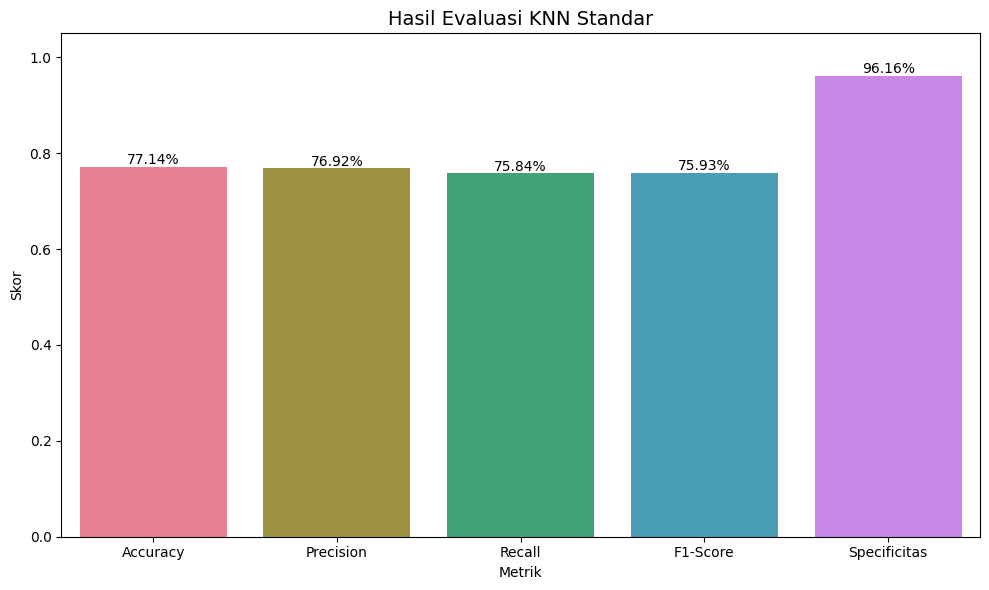

In [70]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Prediksi data uji
y_pred = best_knn.predict(X_test_1)

# Hitung metrik
acc = accuracy_score(y_test_1, y_pred)
prec = precision_score(y_test_1, y_pred, average='macro')
rec = recall_score(y_test_1, y_pred, average='macro')
f1 = f1_score(y_test_1, y_pred, average='macro')

# Hitung specificity per kelas, lalu rata-rata
cm = confusion_matrix(y_test_1, y_pred)
spec_list = []
for i in range(len(cm)):
    tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))  # hapus baris & kolom kelas i
    fp = np.sum(np.delete(cm, i, axis=0)[:, i])  # kolom i tanpa baris i
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0
    spec_list.append(spec)
spec = np.mean(spec_list)  # Rata-rata specificity semua kelas

# Visualisasi
metrik = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Specificitas']
skor = [acc, prec, rec, f1, spec]

plt.figure(figsize=(10, 6))
sns.barplot(x=metrik, y=skor, palette='husl')

for i, value in enumerate(skor):
    plt.text(i, value + 0.005, f'{value*100:.2f}%', ha='center')

plt.title('Hasil Evaluasi KNN Standar', fontsize=14)
plt.xlabel('Metrik')
plt.ylabel('Skor')
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()


# Model 2: KNN+Gabor

In [25]:
# Split data
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=0.1, random_state=42)

In [26]:
print("\n=== 1. KNN Standar ===")

# Tuning hyperparameter KNN
param_grid = {
    'n_neighbors': [3],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}


=== 1. KNN Standar ===


In [27]:
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_2, y_train_2)

best_knn = grid_search.best_estimator_
print(f"Parameter terbaik: {grid_search.best_params_}")

Parameter terbaik: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}


## Ekstraksi Fitur Gabor

In [28]:
from skimage.feature import graycomatrix, graycoprops
def extract_features_from_gabor(gabor_image_path):
    """Extract texture features from pre-computed Gabor images"""
    try:
        # Load Gabor-filtered image
        img = io.imread(gabor_image_path)

        # Handle 4-channel (RGBA) images by taking only RGB channels
        if img.shape[-1] == 4:
            img = img[..., :3]  # Discard alpha channel

        # Convert to grayscale
        if len(img.shape) == 3:
            img = color.rgb2gray(img)

        # Verify image dimensions
        if img.size == 0:
            print(f"Empty image: {gabor_image_path}")
            return None

        # Calculate GLCM properties
        glcm = graycomatrix((img * 255).astype(np.uint8),
                          distances=[1, 3],  # Multiple distances
                          angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                          symmetric=True,
                          normed=True)

        # Extract texture properties
        properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
        features = []
        for prop in properties:
            features.extend(graycoprops(glcm, prop).ravel())

        return np.array(features)

    except Exception as e:
        print(f"Error processing {gabor_image_path}: {str(e)}")
        return None

In [29]:
# Path ke dataset Gabor
output_gabor_dir = '/content/drive/MyDrive/uang kertas 2024/combined_dataset_v8'

In [30]:
def load_gabor_dataset(gabor_dir):
    image_paths = []
    labels = []

    for class_name in os.listdir(gabor_dir):
        class_dir = os.path.join(gabor_dir, class_name)
        if os.path.isdir(class_dir):
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(class_dir, img_name)
                    image_paths.append(img_path)
                    labels.append(class_name)

    return image_paths, labels

In [31]:
def load_and_extract_features_with_labels(gabor_dir):
    """Load images and extract features while maintaining label alignment"""
    image_paths = []
    labels = []

    # Load all image paths and labels
    print("Collecting image paths and labels...")
    for class_name in tqdm(os.listdir(gabor_dir), desc="Processing Classes"):
        class_dir = os.path.join(gabor_dir, class_name)
        if os.path.isdir(class_dir):
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_paths.append(os.path.join(class_dir, img_name))
                    labels.append(class_name)

    # Now extract features while maintaining alignment
    features = []
    valid_labels = []

    print("\nExtracting features with label alignment...")
    with ThreadPoolExecutor(max_workers=multiprocessing.cpu_count()) as executor:
        # Create a list of futures (feature, label) pairs
        futures = []
        for img_path, label in zip(image_paths, labels):
            futures.append((executor.submit(extract_texture_features, img_path), label))

        # Process results as they complete
        for future, label in tqdm(futures, desc="Extracting Features"):
            try:
                feat = future.result()
                if feat is not None:
                    features.append(feat)
                    valid_labels.append(label)
            except Exception as e:
                print(f"Skipping image due to error: {str(e)}")

    return np.array(features), valid_labels

In [32]:
from concurrent.futures import ThreadPoolExecutor
def parallel_feature_extraction(image_paths, labels=None):
    features_list = []
    valid_paths = []
    valid_labels = []

    with ThreadPoolExecutor(max_workers=multiprocessing.cpu_count()) as executor:
        results = list(tqdm(executor.map(extract_features_from_gabor, image_paths),
                      total=len(image_paths),
                      desc="Ekstraksi Fitur GLCM"))

    for idx, (features, img_path) in enumerate(zip(results, image_paths)):
        if features is not None:
            features_list.append(features)
            valid_paths.append(img_path)
            if labels is not None:
                valid_labels.append(labels[idx])

    return np.array(features_list), valid_paths, valid_labels

In [33]:
# Memuat dataset Gabor
print("Memuat dataset Gabor yang sudah diproses...")
gabor_paths, gabor_labels = load_gabor_dataset(output_gabor_dir)

Memuat dataset Gabor yang sudah diproses...


In [34]:
!pip install tqdm
from tqdm import tqdm  # Import tqdm here
import os
import numpy as np

def load_and_extract_features_with_labels(gabor_dir):
    """Load images and extract features while maintaining label alignment"""
    image_paths = []
    labels = []

    # Load all image paths and labels
    print("Collecting image paths and labels...")
    for class_name in tqdm(os.listdir(gabor_dir), desc="Processing Classes"):
        class_dir = os.path.join(gabor_dir, class_name)
        if os.path.isdir(class_dir):
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_paths.append(os.path.join(class_dir, img_name))
                    labels.append(class_name)

    # Now extract features while maintaining alignment
    features = []
    valid_labels = []

    print("\nExtracting features with label alignment...")
    for img_path, label in tqdm(zip(image_paths, labels), desc="Extracting Features"):
        try:
            # Assuming 'extract_features_from_gabor' is your feature extraction function
            feat = extract_features_from_gabor(img_path)
            if feat is not None:
                features.append(feat)
                valid_labels.append(label)
            else:
                print(f"Warning: Feature extraction failed for {img_path}")
        except Exception as e:
            print(f"Error processing {img_path}: {str(e)}")

    # Convert to numpy arrays
    features = np.array(features) if features else np.empty((0, 0))  # Handle empty case
    valid_labels = np.array(valid_labels) if valid_labels else np.empty((0,))  # Handle empty case

    return features, valid_labels  # Always return a tuple

In [35]:
print("Loading dataset and extracting features...")
X_features, y_labels = load_and_extract_features_with_labels(output_gabor_dir)

Loading dataset and extracting features...


Processing Classes: 100%|██████████| 7/7 [00:00<00:00, 546.28it/s]



Extracting features with label alignment...


Extracting Features: 700it [01:05, 10.63it/s]


In [36]:
# Ekstraksi fitur
import multiprocessing
from tqdm import tqdm

print("\nSplitting dataset...")
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    X_features, y_labels,
    test_size=0.1,
    random_state=42,
    stratify=y_labels
)



Splitting dataset...


Verifikasi shape data

In [37]:
print("\nData dimensions:")
print(f"X_train: {X_train_2.shape}, y_train: {len(y_train_2)}")
print(f"X_test: {X_test_2.shape}, y_test: {len(y_test_2)}")


Data dimensions:
X_train: (630, 40), y_train: 630
X_test: (70, 40), y_test: 70


In [38]:
scaler = StandardScaler()
X_train_gabor = scaler.fit_transform(X_train_2)
X_test_gabor = scaler.transform(X_test_2)

## Latih KNN dengan feature Gabor

In [39]:
knn = KNeighborsClassifier()
param_grid = {
    'n_neighbors': [3],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_2, y_train_2)


print("\nTraining KNN model...")
knn_gabor = KNeighborsClassifier(**grid_search.best_params_)
knn_gabor.fit(X_train_gabor, y_train_2)


Training KNN model...


KNeighborsClassifier(metric='euclidean', n_neighbors=3, weights='distance')

## Evaluasi KNN+GABOR

In [40]:
# Evaluate
y_pred = knn_gabor.predict(X_test_gabor)
print("\nClassification Report:")
print(classification_report(y_test_2, y_pred))


Classification Report:
                    precision    recall  f1-score   support

         1. seribu       1.00      1.00      1.00        10
       2. dua ribu       0.90      0.90      0.90        10
      3. lima ribu       0.91      1.00      0.95        10
   4. sepuluh ribu       1.00      1.00      1.00        10
 5. dua puluh ribu       1.00      1.00      1.00        10
6. lima puluh ribu       1.00      1.00      1.00        10
   7. seratus ribu       1.00      0.90      0.95        10

          accuracy                           0.97        70
         macro avg       0.97      0.97      0.97        70
      weighted avg       0.97      0.97      0.97        70



In [44]:
def evaluate_model_with_cm(model, X_test, y_test, method_name):
    # Prediksi
    y_pred = model.predict(X_test)

    # Hitung akurasi
    acc = accuracy_score(y_test, y_pred)

    # Classification report
    print(f"\n=== Evaluasi {method_name} ===")
    print(f"Akurasi: {acc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    # Use np.unique instead of y_test.unique()
    classes = sorted(np.unique(y_test))

    # Visualisasi Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes,
                yticklabels=classes)
    plt.title(f'Confusion Matrix - {method_name}\nAkurasi: {acc:.2%}', pad=20)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

    return acc


=== Evaluasi Gabor + KNN ===
Akurasi: 0.9714

Classification Report:
                    precision    recall  f1-score   support

         1. seribu       1.00      1.00      1.00        10
       2. dua ribu       0.90      0.90      0.90        10
      3. lima ribu       0.91      1.00      0.95        10
   4. sepuluh ribu       1.00      1.00      1.00        10
 5. dua puluh ribu       1.00      1.00      1.00        10
6. lima puluh ribu       1.00      1.00      1.00        10
   7. seratus ribu       1.00      0.90      0.95        10

          accuracy                           0.97        70
         macro avg       0.97      0.97      0.97        70
      weighted avg       0.97      0.97      0.97        70



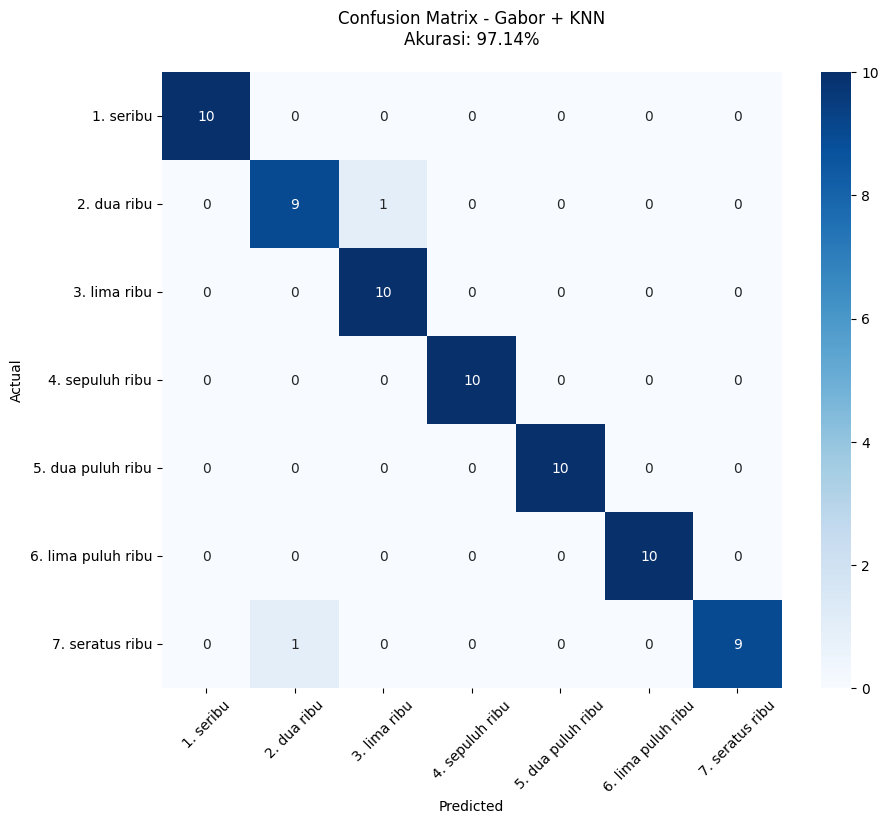

In [45]:
# Mapping label angka ke nama
label_names = {
    '1. seribu': '1. seribu',
    '2. dua ribu': '2. dua ribu',
    '3. lima ribu': '3. lima ribu',
    '4. sepuluh ribu': '4. sepuluh ribu',
    '5. dua puluh ribu': '5. dua puluh ribu',
    '6. lima puluh ribu': '6. lima puluh ribu',
    '7. seratus ribu': '7. seratus ribu'
}


#evaluasi
# Evaluasi model KNN + gabor
#acc_gabor_knn = evaluate_model_with_cm(knn_gabor, X_test_2, y_test_2, "KNN Standar")
acc_gabor_knn = evaluate_model_with_cm(knn_gabor, X_test_gabor, y_test_2, "Gabor + KNN")

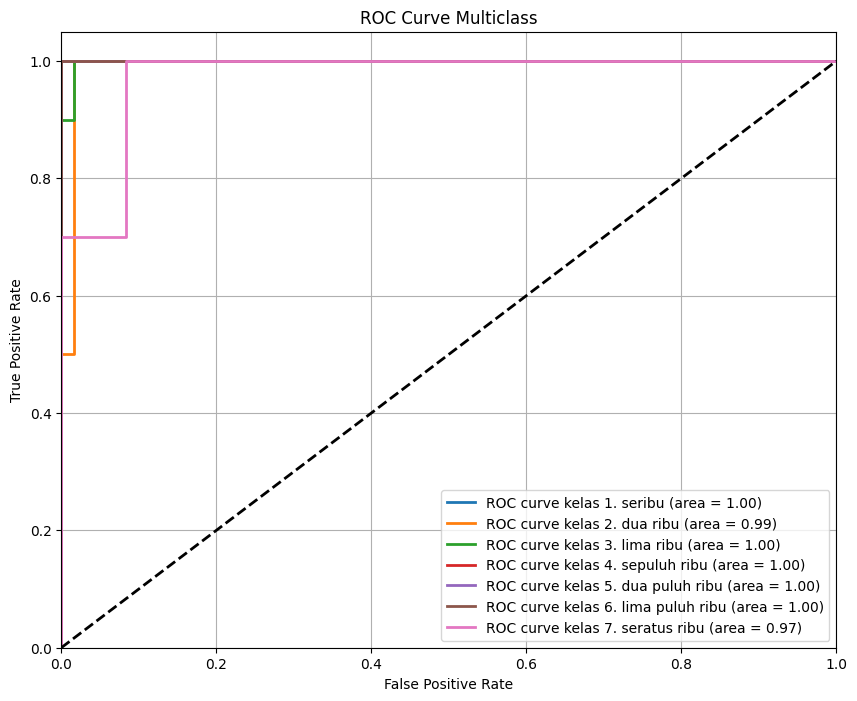

In [46]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Binarize labels
classes = np.unique(y_test_2)
y_test_bin = label_binarize(y_test_2, classes=classes)
n_classes = y_test_bin.shape[1]

# Dapatkan skor prediksi
y_score = knn_gabor.predict_proba(X_test_gabor)

# Hitung FPR, TPR untuk tiap kelas
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curve
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve kelas {classes[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Multiclass')
plt.legend(loc="lower right")
plt.grid()
plt.show()

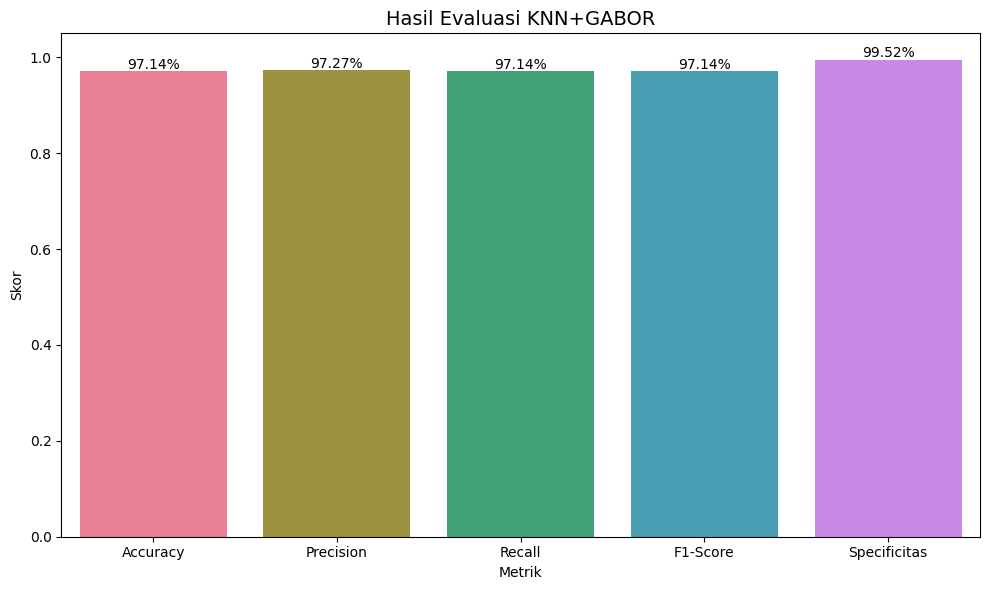

In [69]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Prediksi data uji
y_pred = knn_gabor.predict(X_test_gabor)

# Hitung metrik
acc = accuracy_score(y_test_2, y_pred)
prec = precision_score(y_test_2, y_pred, average='macro')
rec = recall_score(y_test_2, y_pred, average='macro')
f1 = f1_score(y_test_2, y_pred, average='macro')

# Hitung specificity per kelas, lalu rata-rata
cm = confusion_matrix(y_test_2, y_pred)
spec_list = []
for i in range(len(cm)):
    tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))  # hapus baris & kolom kelas i
    fp = np.sum(np.delete(cm, i, axis=0)[:, i])  # kolom i tanpa baris i
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0
    spec_list.append(spec)
spec = np.mean(spec_list)  # Rata-rata specificity semua kelas

# Visualisasi
metrik = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Specificitas']
skor = [acc, prec, rec, f1, spec]

plt.figure(figsize=(10, 6))
sns.barplot(x=metrik, y=skor, palette='husl')

for i, value in enumerate(skor):
    plt.text(i, value + 0.005, f'{value*100:.2f}%', ha='center')

plt.title('Hasil Evaluasi KNN+GABOR', fontsize=14)
plt.xlabel('Metrik')
plt.ylabel('Skor')
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()


# Model 3: KNN + PCA

In [49]:
# Split data
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X, y, test_size=0.1, random_state=42)

In [50]:
print("\n=== 3. PCA + KNN ===")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_3)
X_test_scaled = scaler.transform(X_test_3)


=== 3. PCA + KNN ===


## Aplikasi PCA

In [51]:
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Jumlah komponen PCA: {pca.n_components_}")

Jumlah komponen PCA: 3


##Latih KNN dengan fitur PCA

In [52]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier


knn = KNeighborsClassifier()
pipeline = Pipeline([('knn', knn)])

param_grid = {
    'knn__n_neighbors': [3],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
}


grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy') # Adjust cv and scoring as needed
grid_search.fit(X_train_scaled, y_train_3) # Assuming X_train_scaled and y_train_3 are already defined


print("Best Hyperparameters:", grid_search.best_params_)


Best Hyperparameters: {'knn__metric': 'manhattan', 'knn__n_neighbors': 3, 'knn__weights': 'distance'}


In [53]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Buat pipeline
knn_pca = Pipeline([
    ('pca', PCA(n_components=min(30, X_train_3.shape[1]))),
    ('knn', KNeighborsClassifier(n_neighbors=3, weights='distance'))
])

# Training
knn_pca.fit(X_train_3, y_train_3)


Pipeline(steps=[('pca', PCA(n_components=5)),
                ('knn',
                 KNeighborsClassifier(n_neighbors=3, weights='distance'))])

## Evaluasi KNN+PCA


=== Evaluasi PCA + KNN ===
Akurasi: 0.7714

Classification Report:
                    precision    recall  f1-score   support

         1. seribu       0.70      0.64      0.67        11
       2. dua ribu       0.83      0.83      0.83        12
      3. lima ribu       0.50      0.67      0.57         6
   4. sepuluh ribu       1.00      1.00      1.00         8
 5. dua puluh ribu       0.86      0.60      0.71        10
6. lima puluh ribu       0.80      0.92      0.86        13
   7. seratus ribu       0.70      0.70      0.70        10

          accuracy                           0.77        70
         macro avg       0.77      0.77      0.76        70
      weighted avg       0.78      0.77      0.77        70



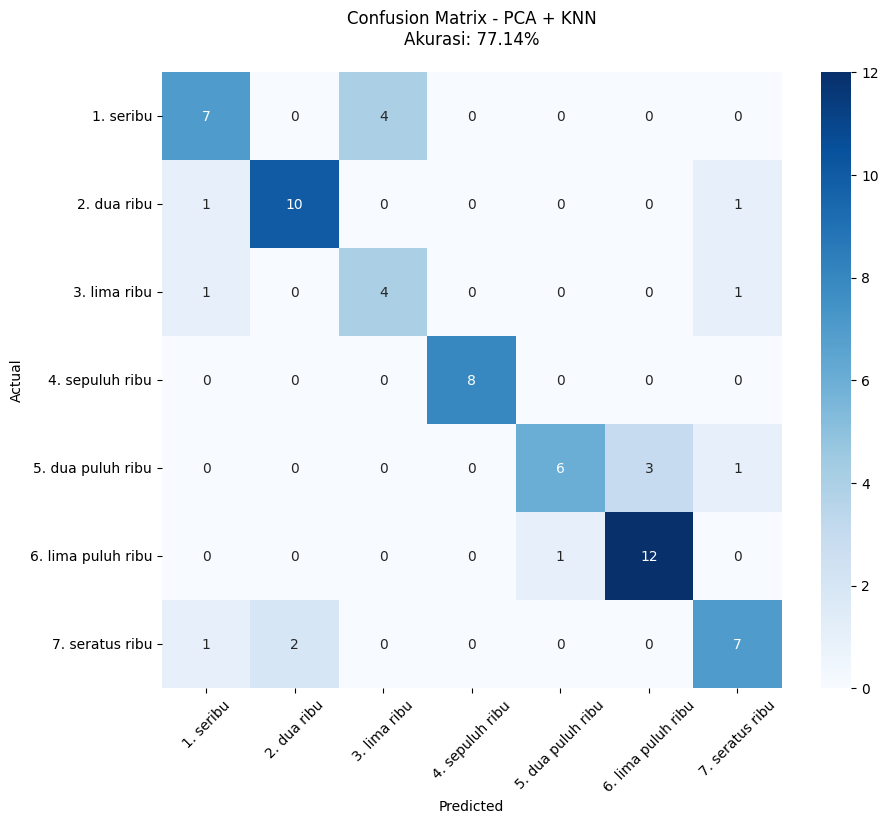

In [55]:
# Mapping label angka ke nama
label_names = {
    '1. seribu': '1. seribu',
    '2. dua ribu': '2. dua ribu',
    '3. lima ribu': '3. lima ribu',
    '4. sepuluh ribu': '4. sepuluh ribu',
    '5. dua puluh ribu': '5. dua puluh ribu',
    '6. lima puluh ribu': '6. lima puluh ribu',
    '7. seratus ribu': '7. seratus ribu'
}


#evaluasi
acc_knn_pca = evaluate_model_with_cm(knn_pca, X_test_3, y_test_3, "PCA + KNN")

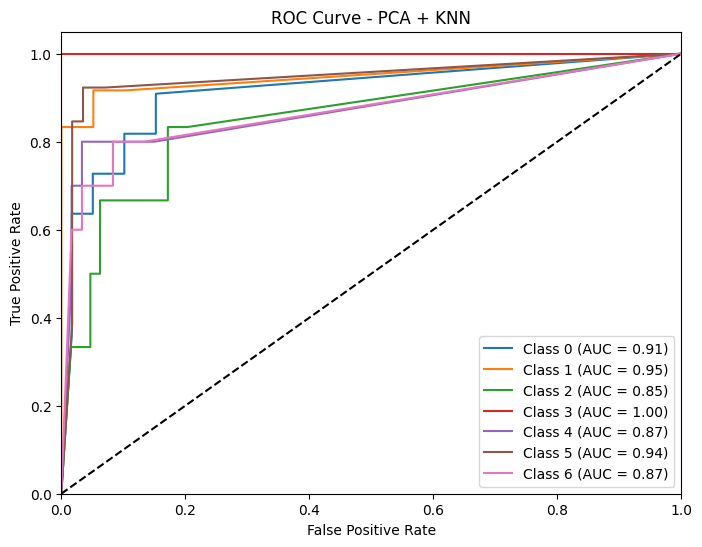

In [56]:
# ROC Curve
plot_roc_curve(knn_pca, X_test_3, y_test_3, "PCA + KNN")

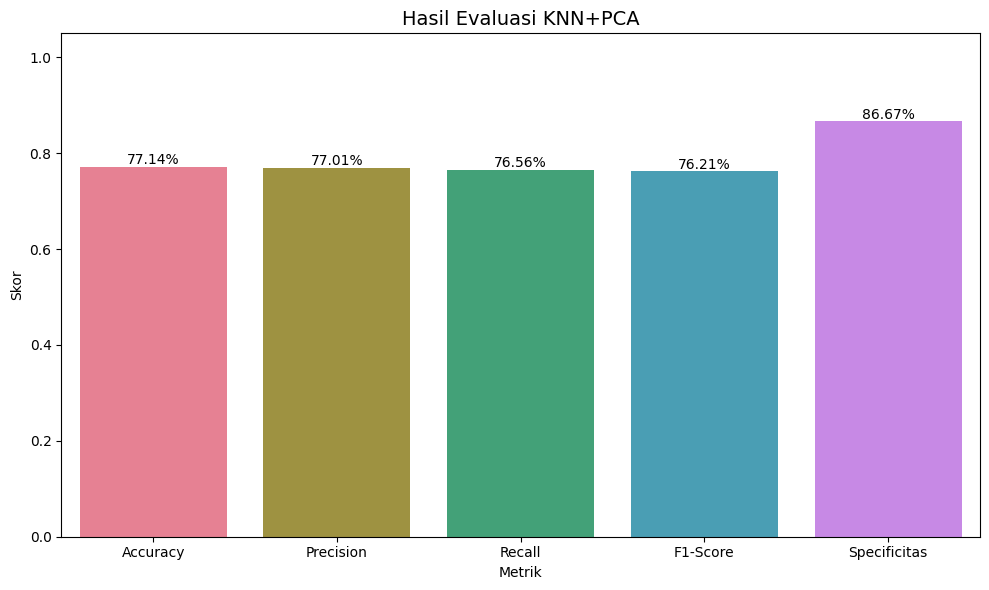

In [68]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Prediksi data uji
y_pred = knn_pca.predict(X_test_3)

# Hitung metrik
acc = accuracy_score(y_test_3, y_pred)
prec = precision_score(y_test_3, y_pred, average='macro')
rec = recall_score(y_test_3, y_pred, average='macro')
f1 = f1_score(y_test_3, y_pred, average='macro')

# Hitung specificity
cm = confusion_matrix(y_test_2, y_pred)
spec_list = []
for i in range(len(cm)):
    tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
    fp = np.sum(np.delete(cm, i, axis=0)[:, i])
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0
    spec_list.append(spec)
spec = np.mean(spec_list)  # Rata-rata specificity semua kelas

# Visualisasi
metrik = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Specificitas']
skor = [acc, prec, rec, f1, spec]

plt.figure(figsize=(10, 6))
sns.barplot(x=metrik, y=skor, palette='husl')

for i, value in enumerate(skor):
    plt.text(i, value + 0.005, f'{value*100:.2f}%', ha='center')

plt.title('Hasil Evaluasi KNN+PCA', fontsize=14)
plt.xlabel('Metrik')
plt.ylabel('Skor')
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()


# Model 4: KNN+GABOR+PCA

In [58]:
# 5. Split the dataset into training and testing sets
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(
    X_features, y_labels, test_size=0.1, random_state=42, stratify=y_labels
)


In [59]:
# 6. Standardize the data
scaler = StandardScaler()
X_train_gabor = scaler.fit_transform(X_train_4)
X_test_gabor = scaler.transform(X_test_4)

# 7. Apply PCA for dimensionality reduction
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_train_pca = pca.fit_transform(X_train_gabor)
X_test_pca = pca.transform(X_test_gabor)

print(f"Jumlah komponen PCA: {pca.n_components_}")

Jumlah komponen PCA: 4


In [60]:
# 8. KNN classifier dengan GridSearchCV untuk tuning hyperparameter
knn = KNeighborsClassifier()
param_grid = {
    'n_neighbors': [3],  # Mencoba beberapa nilai n_neighbors
    'weights': ['uniform', 'distance'],  # Mencoba dua pilihan untuk 'weights'
    'metric': ['euclidean', 'manhattan']  # Mencoba dua jenis metric (jarak)
}

# GridSearchCV untuk mencari parameter terbaik dengan cross-validation (cv=5)
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_pca, y_train_4)  # Melatih GridSearchCV dengan data training

# 9. Train KNN model dengan parameter terbaik dari GridSearch
knn_gabor_pca = KNeighborsClassifier(**grid_search.best_params_)  # Menggunakan parameter terbaik dari GridSearchCV
knn_gabor_pca.fit(X_train_pca, y_train_4)  # Latih model dengan data training

# Setelah model terlatih, kamu bisa melakukan prediksi pada data test dan evaluasi performa model

KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')

## Evaluasi KNN + GABOR + PCA


=== Evaluasi KNN + GABOR +PCA  ===
Akurasi: 0.8429

Classification Report:
                    precision    recall  f1-score   support

         1. seribu       0.88      0.70      0.78        10
       2. dua ribu       0.73      0.80      0.76        10
      3. lima ribu       0.90      0.90      0.90        10
   4. sepuluh ribu       1.00      0.90      0.95        10
 5. dua puluh ribu       1.00      0.80      0.89        10
6. lima puluh ribu       0.91      1.00      0.95        10
   7. seratus ribu       0.62      0.80      0.70        10

          accuracy                           0.84        70
         macro avg       0.86      0.84      0.85        70
      weighted avg       0.86      0.84      0.85        70



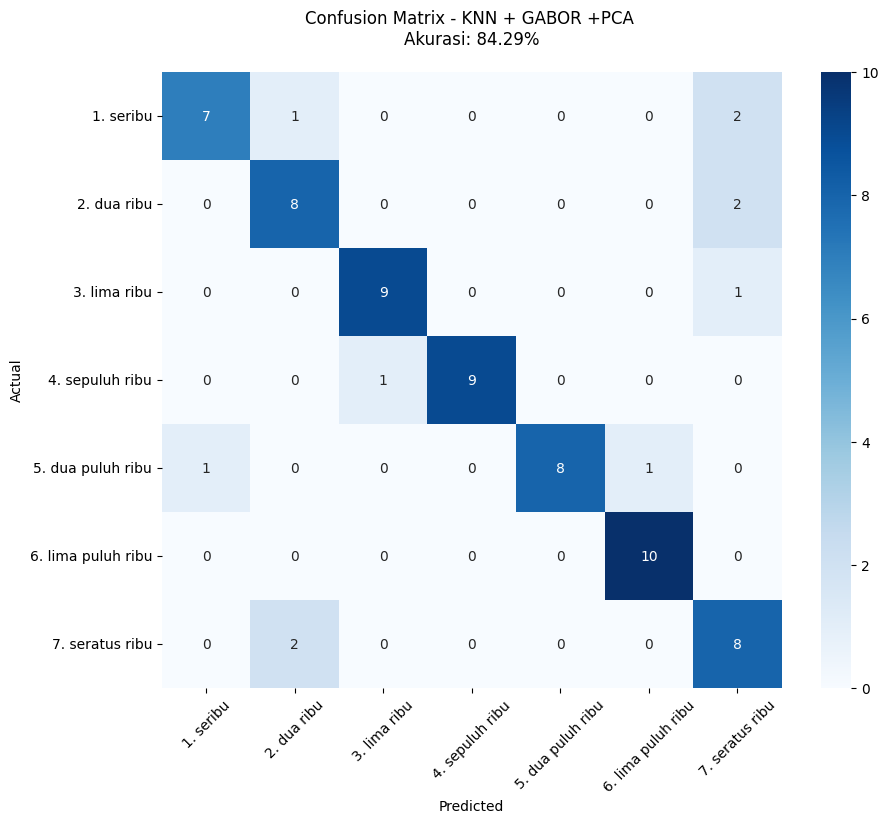

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

#evaluasi
acc_knn_gabor_pca = evaluate_model_with_cm(knn_gabor_pca, X_test_pca, y_test_4, "KNN + GABOR +PCA ")


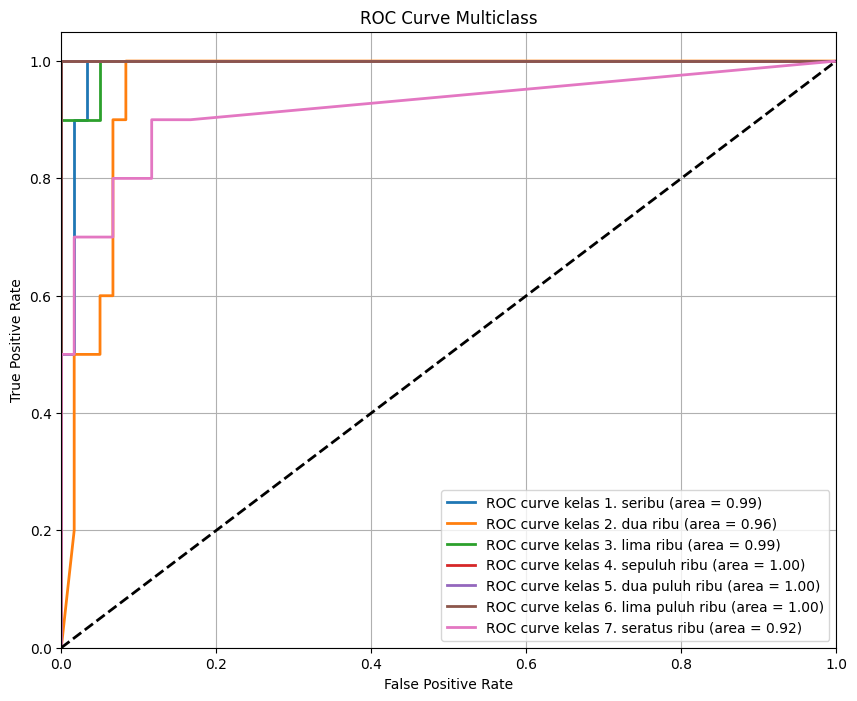

In [63]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Binarize labels
classes = np.unique(y_test_4)
y_test_bin = label_binarize(y_test_4, classes=classes)
n_classes = y_test_bin.shape[1]

# Dapatkan skor prediksi
y_score = knn_gabor_pca.predict_proba(X_test_pca)

# Hitung FPR, TPR untuk tiap kelas
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curve
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve kelas {classes[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Multiclass')
plt.legend(loc="lower right")
plt.grid()
plt.show()


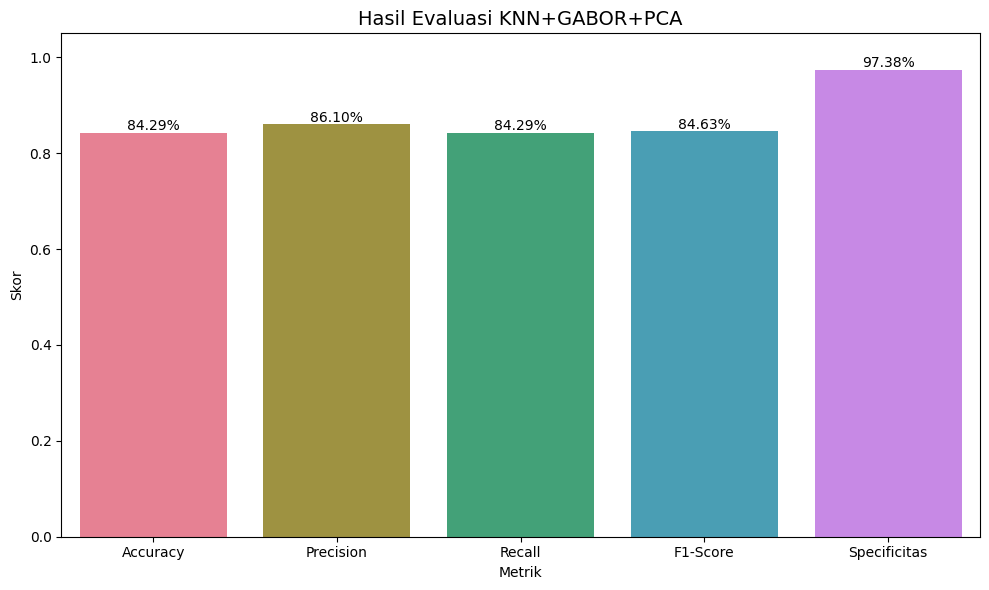

In [67]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Prediksi data uji
y_pred = knn_gabor_pca.predict(X_test_pca)

# Hitung metrik
acc = accuracy_score(y_test_4, y_pred)
prec = precision_score(y_test_4, y_pred, average='macro')
rec = recall_score(y_test_4, y_pred, average='macro')
f1 = f1_score(y_test_4, y_pred, average='macro')

# Hitung specificity
cm = confusion_matrix(y_test_2, y_pred)
spec_list = []
for i in range(len(cm)):
    tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
    fp = np.sum(np.delete(cm, i, axis=0)[:, i])
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0
    spec_list.append(spec)
spec = np.mean(spec_list)  # Rata-rata specificity semua kelas

# Visualisasi
metrik = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Specificitas']
skor = [acc, prec, rec, f1, spec]

plt.figure(figsize=(10, 6))
sns.barplot(x=metrik, y=skor, palette='husl')

for i, value in enumerate(skor):
    plt.text(i, value + 0.005, f'{value*100:.2f}%', ha='center')

plt.title('Hasil Evaluasi KNN+GABOR+PCA', fontsize=14)
plt.xlabel('Metrik')
plt.ylabel('Skor')
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()


# Nilai specifitas

#Perbandingan Model

In [ ]:
print("\n=== Perbandingan Akurasi Semua Metode ===")

results = pd.DataFrame({
    'Metode': ['KNN Standar', 'KNN + Gabor', 'KNN + PCA', 'KNN + GABOR + PCA'],
    'Akurasi': [acc_knn, acc_gabor_knn, acc_knn_pca, acc_knn_gabor_pca]
})

print("\nTabel Perbandingan:")
print(results)


=== Perbandingan Akurasi Semua Metode ===

Tabel Perbandingan:
              Metode   Akurasi
0        KNN Standar  0.771429
1        KNN + Gabor  0.971429
2          KNN + PCA  0.771429
3  KNN + GABOR + PCA  0.842857


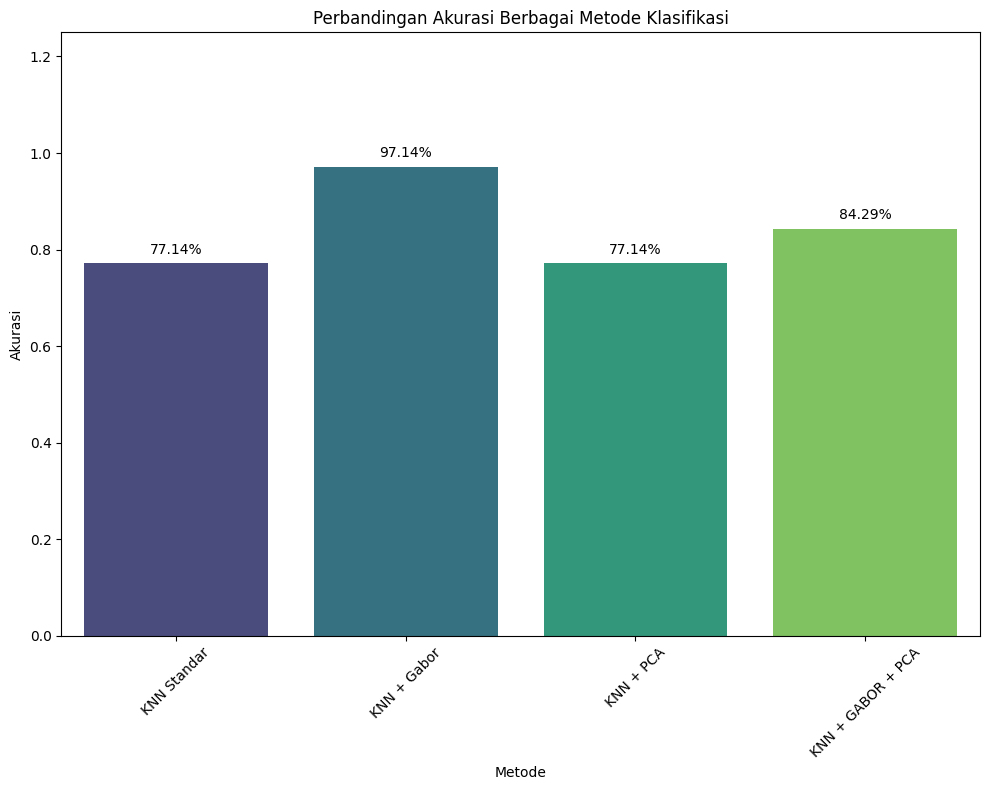

In [ ]:
# Visualisasi perbandingan
plt.figure(figsize=(10, 8))
sns.barplot(x='Metode', y='Akurasi', data=results, palette='viridis')
plt.title('Perbandingan Akurasi Berbagai Metode Klasifikasi')
plt.ylim(0, 1.25)
plt.ylabel('Akurasi')
plt.xticks(rotation=45)
for index, row in results.iterrows():
    plt.text(index, row.Akurasi + 0.02, f'{row.Akurasi:.2%}', color='black', ha="center")
plt.tight_layout()
plt.show()
